In [35]:
# Import library
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# Load data
df = pd.read_excel('../data.xlsx', sheet_name='Rekapan')

In [37]:
# Muncul data awal dan akhir
print(df.head())
print(df.tail())

     Tanggal         Nama Customer                        Lokasi Customer  \
0 2018-01-01  TOA GALVA INDUSTRIES  -6.398580325820022, 106.8648544138663   
1 2018-01-01  TOA GALVA INDUSTRIES  -6.398580325820022, 106.8648544138663   
2 2018-01-01  TOA GALVA INDUSTRIES  -6.398580325820022, 106.8648544138663   
3 2018-01-01  TOA GALVA INDUSTRIES  -6.398580325820022, 106.8648544138663   
4 2018-01-01  TOA GALVA INDUSTRIES  -6.398580325820022, 106.8648544138663   

            Nama Produk  Type Produk       SO  TERKIRIM SISA PO INTERNAL  \
0          FIXING SCREW  Accessories  31500.0   31500.0       0        -   
1       BS-1020 BRACKET  Accessories  14900.0   13600.0    1300        -   
2  HX-SW HANDLE BRACKET  Accessories    250.0     250.0       0        -   
3          TC-303 ANGLE  Accessories  29000.0   16390.0   12610        -   
4          TC-615 ANGLE  Accessories   1650.0    1650.0       0        -   

  EKSTERNAL  Harga Komoditas Bijih Besi Indeks Produksi Dalam Negeri  \
0       

                             Tanggal            SO      TERKIRIM  \
count                          19680  1.968000e+04  1.889100e+04   
mean   2021-03-27 01:16:23.414633984  1.189907e+04  1.098127e+04   
min              2018-01-01 00:00:00  1.000000e+00  0.000000e+00   
25%              2019-07-01 00:00:00  6.000000e+02  6.000000e+02   
50%              2021-06-01 00:00:00  3.000000e+03  2.500000e+03   
75%              2022-12-01 00:00:00  9.300000e+03  8.100000e+03   
max              2024-04-01 00:00:00  3.000000e+06  1.750000e+06   
std                              NaN  5.399271e+04  4.592784e+04   

       Harga Komoditas Bijih Besi  Data Inflasi          Kurs  
count                19680.000000  19680.000000  19680.000000  
mean                   112.526491      0.030203  14672.027591  
min                     64.350000      0.013200  13413.000000  
25%                     89.550000      0.021800  14229.000000  
50%                    110.910000      0.030000  14480.000000  
75%

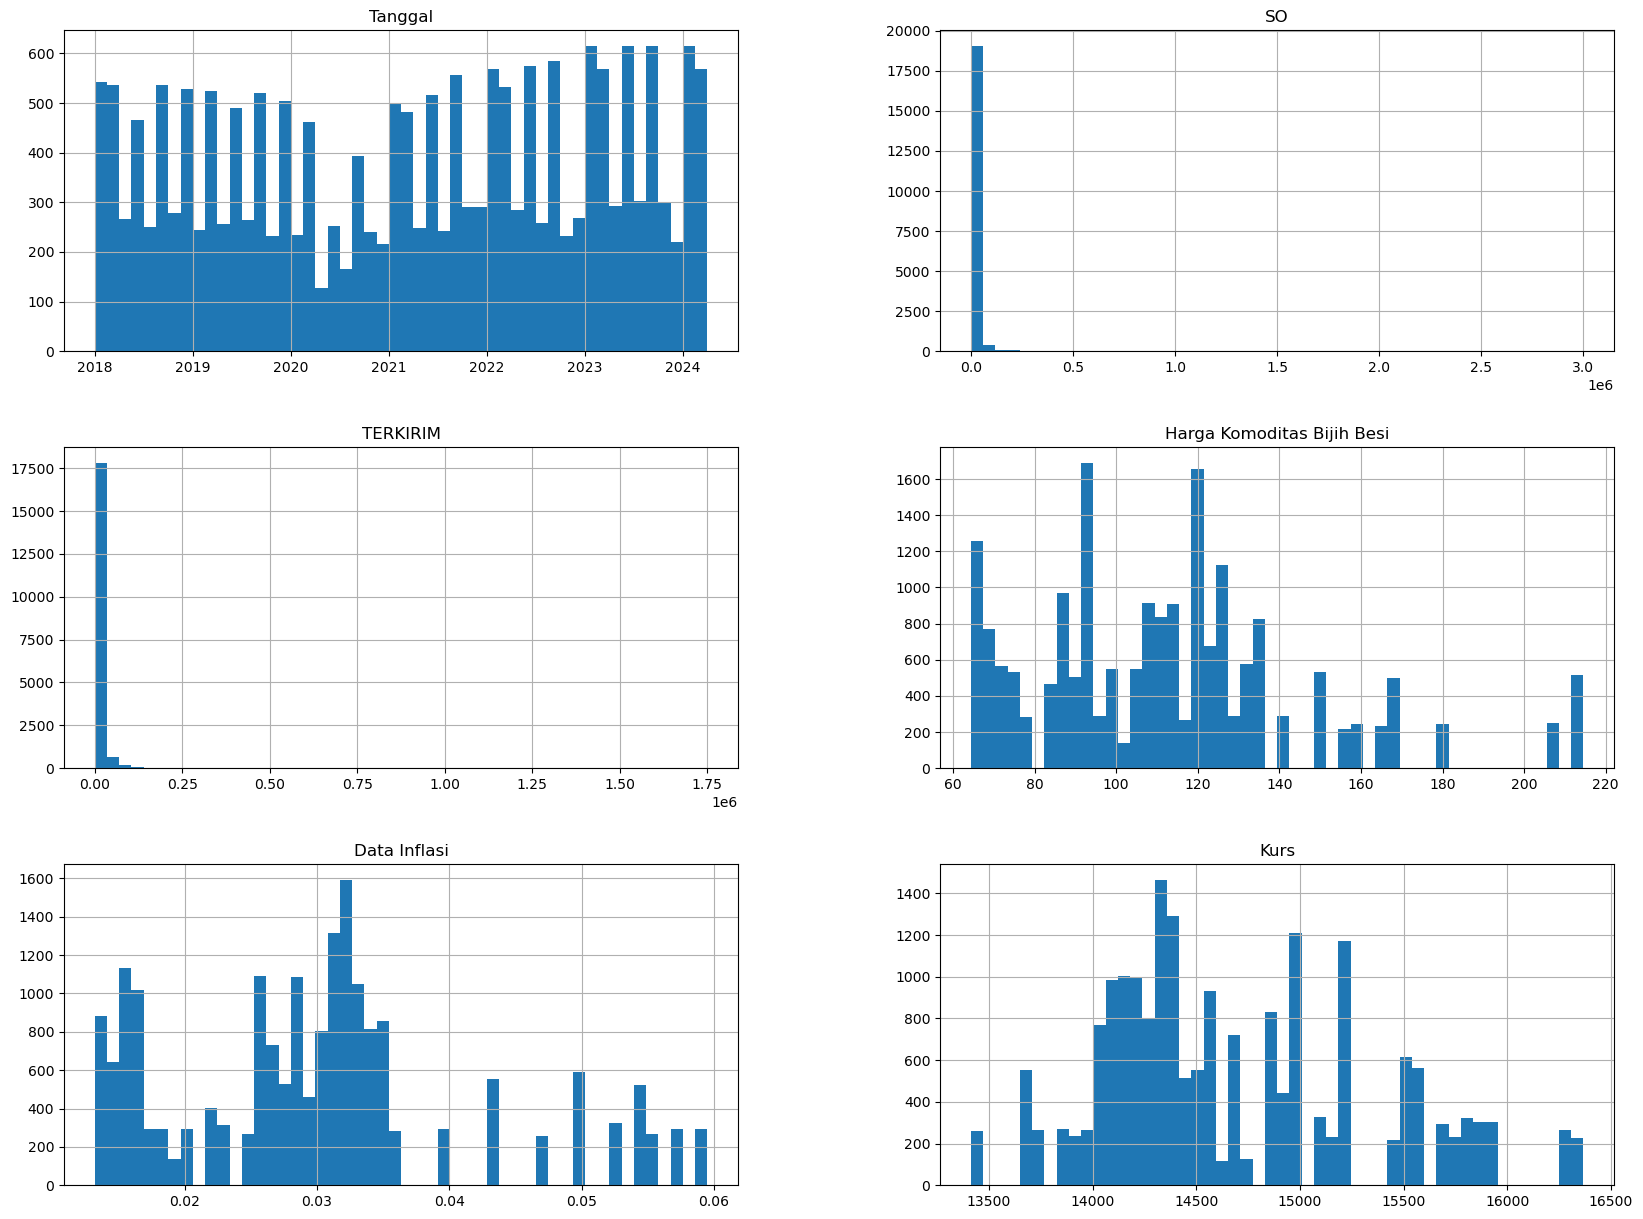

In [38]:
# Statistik deskriptif dasar
print(df.describe())

# Cek nilai yang hilang
print(df.isnull().sum())

# Visualisasi distribusi data
df.hist(bins=50, figsize=(20, 15))
plt.show()

                              count          mean           std         min  \
SO                            19680  11899.069842  53992.713385      1.0000   
TERKIRIM                      18891  10981.270632  45927.836627      0.0000   
Harga Komoditas Bijih Besi    19680    112.526491     33.514906     64.3500   
Indeks Produksi Dalam Negeri  19414    146.218267      9.191533    104.0200   
Data Inflasi                  19680      0.030203      0.011573      0.0132   
Kurs                          19680  14672.027591    641.669982  13413.0000   

                                     25%       50%        75%           max  
SO                              600.0000   3000.00   9300.000  3.000000e+06  
TERKIRIM                        600.0000   2500.00   8100.000  1.750000e+06  
Harga Komoditas Bijih Besi       89.5500    110.91    127.060  2.145500e+02  
Indeks Produksi Dalam Negeri    142.0000    148.05    151.870  1.613900e+02  
Data Inflasi                      0.0218      0.03      

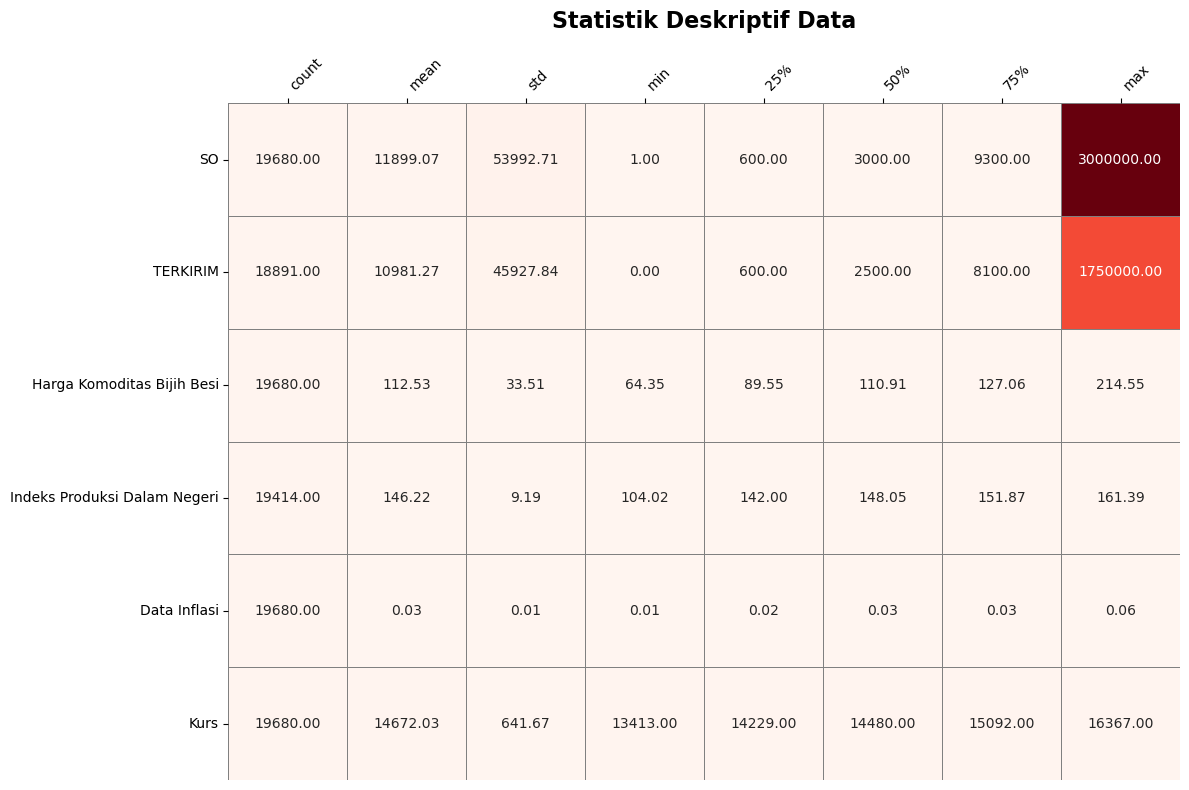

In [39]:
# Filtering only the relevant columns for descriptive statistics
data_filtered = df[['SO', 'TERKIRIM', 'Harga Komoditas Bijih Besi', 
                    'Indeks Produksi Dalam Negeri', 'Data Inflasi', 'Kurs']]

# Converting relevant columns to numeric
data_filtered = data_filtered.apply(pd.to_numeric, errors='coerce')

# Calculating descriptive statistics
descriptive_stats = data_filtered.describe().transpose()

# Adding additional statistics: count of non-null values
descriptive_stats['count'] = data_filtered.count()

# Reordering the columns for clarity
descriptive_stats = descriptive_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

# Displaying the descriptive statistics
print(descriptive_stats)

# Creating a heatmap-like table for descriptive statistics
fig, ax = plt.subplots(figsize=(12, 8))

# Visualizing the descriptive statistics using heatmap style
sns.heatmap(descriptive_stats, annot=True, fmt=".2f", cmap="Reds", cbar=False, ax=ax, 
            linewidths=0.5, linecolor='gray', xticklabels=True, yticklabels=True)

# Adjusting the x-axis labels to be at the top
ax.xaxis.tick_top()

# Setting title and layout adjustments
ax.set_title('Statistik Deskriptif Data', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='left')
plt.tight_layout()

# Display the plot
plt.show()

In [40]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Combine into a DataFrame
missing_df = pd.DataFrame({
    'Number_of_NaN': missing_values,
    'Percent(%)': missing_percentage
}).reset_index()

# Rename the columns for clarity
missing_df.columns = ['Column', 'Number_of_NaN', 'Percent(%)']

# Display the result
print(missing_df)



                          Column  Number_of_NaN  Percent(%)
0                        Tanggal              0    0.000000
1                  Nama Customer              0    0.000000
2                Lokasi Customer              0    0.000000
3                    Nama Produk              0    0.000000
4                    Type Produk              0    0.000000
5                             SO              0    0.000000
6                       TERKIRIM            789    4.009146
7                        SISA PO             27    0.137195
8                       INTERNAL              0    0.000000
9                      EKSTERNAL              0    0.000000
10    Harga Komoditas Bijih Besi              0    0.000000
11  Indeks Produksi Dalam Negeri              0    0.000000
12                  Data Inflasi              0    0.000000
13                          Kurs              0    0.000000


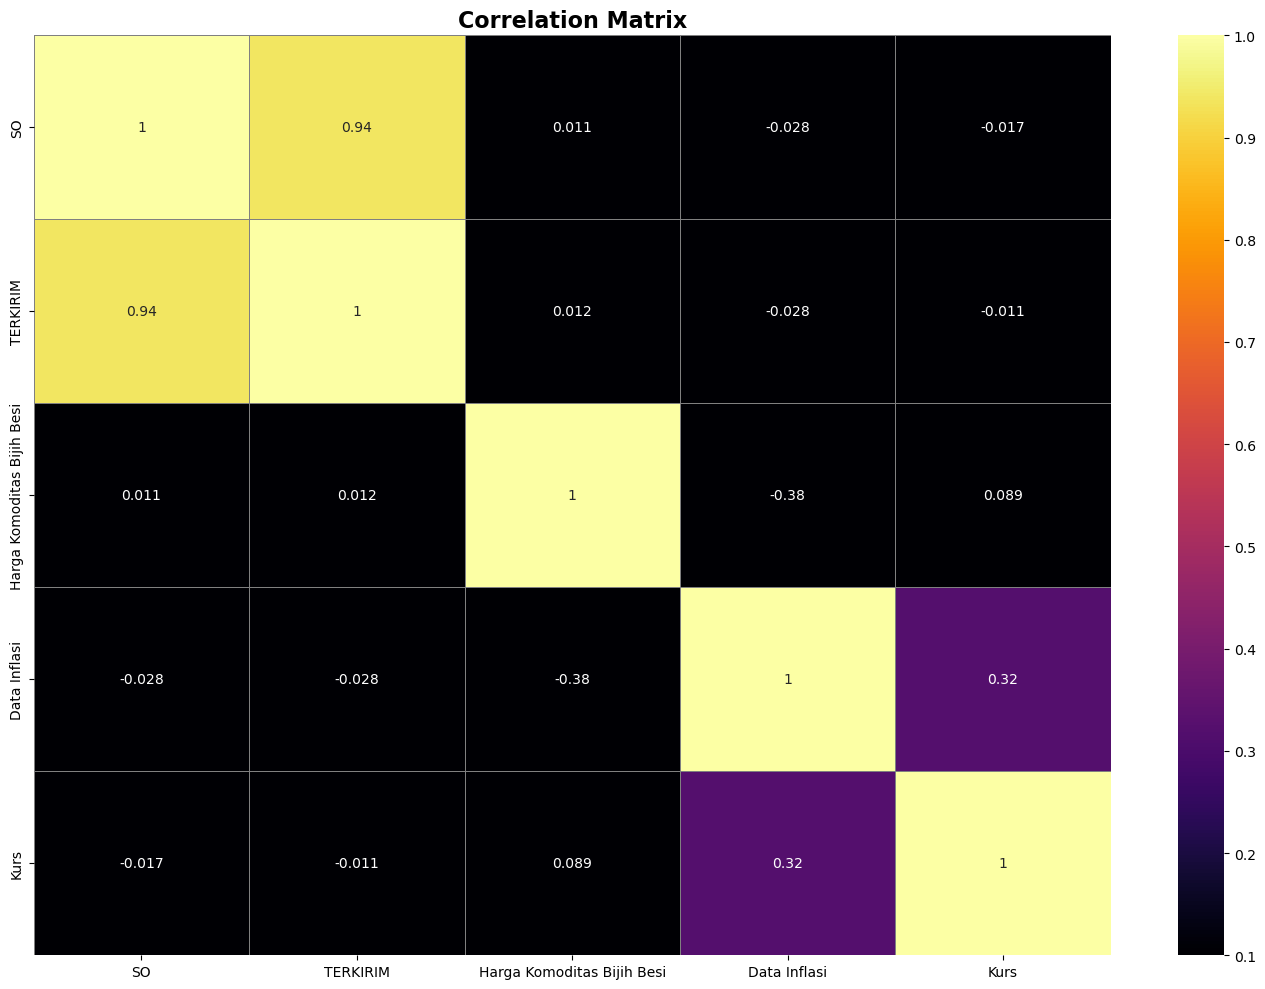

In [46]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='inferno', vmin=0.1, vmax=1, linewidths=0.5, linecolor='gray')
plt.title('Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [41]:
# Filter kolom terkait
data_filtered = df[['Tanggal', 'SO', 'TERKIRIM', 'Harga Komoditas Bijih Besi', 'Indeks Produksi Dalam Negeri', 'Data Inflasi', 'Kurs']]

# Ganti nama kolom
data_filtered.columns = ['Tanggal', 'SO', 'Terkirim', 'Harga Komoditas', 'Indeks Produksi', 'Data Inflasi', 'Kurs']

# Konversi tipe data
data_filtered['Tanggal'] = pd.to_datetime(data_filtered['Tanggal'])

# Ganti tipe data 'Indeks Produksi'
data_filtered['Indeks Produksi'] = pd.to_numeric(data_filtered['Indeks Produksi'], errors='coerce')

# Buat kolom 'bulan_tahun'
data_filtered['bulan_tahun'] = data_filtered['Tanggal'].dt.to_period('M')

# Rekapan Bulanan
monthly_summary = data_filtered.groupby('bulan_tahun').agg({
    'SO': 'sum',
    # Uncomment other columns as needed
    # 'Terkirim': 'sum',
    # 'Harga Komoditas': 'mean',
    # 'Indeks Produksi': 'mean',
    # 'Data Inflasi': 'mean',
    # 'Kurs': 'mean'
}).reset_index()

# Muncul Rekapan Bulanan
print(monthly_summary)

   bulan_tahun         SO
0      2018-01  2845126.0
1      2018-02  2751060.0
2      2018-03  3751325.0
3      2018-04  3350350.0
4      2018-05  2733224.0
..         ...        ...
71     2023-12  2022755.0
72     2024-01  2847896.0
73     2024-02  2730829.0
74     2024-03  2765759.0
75     2024-04  2020844.0

[76 rows x 2 columns]


C:\Users\Christian Kencana\AppData\Local\Temp\ipykernel_8644\1992146000.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Tanggal'] = pd.to_datetime(data_filtered['Tanggal'])
C:\Users\Christian Kencana\AppData\Local\Temp\ipykernel_8644\1992146000.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Indeks Produksi'] = pd.to_numeric(data_filtered['Indeks Produksi'], errors='coerce')
C:\Users\Christian Kencana\AppData\Local\Temp\ipykernel_8644\1992146000.py:14: SettingWithCopyW

In [42]:
# Set alpha value for SES
alpha = 0.1

# Initialize columns for SES forecast and error metrics
monthly_summary['SES Forecast'] = np.nan
monthly_summary['Error'] = np.nan
monthly_summary['MAD'] = np.nan
monthly_summary['MSE'] = np.nan
monthly_summary['MAPE'] = np.nan

# Set initial forecast to the first SO value
monthly_summary.loc[0, 'SES Forecast'] = monthly_summary.loc[0, 'SO']

# Apply SES formula and calculate error metrics for each subsequent row
for i in range(1, len(monthly_summary)):
    # SES Forecast
    monthly_summary.loc[i, 'SES Forecast'] = (alpha * monthly_summary.loc[i-1, 'SO']) + ((1 - alpha) * monthly_summary.loc[i-1, 'SES Forecast'])
    
    # Error
    monthly_summary.loc[i, 'Error'] = monthly_summary.loc[i, 'SO'] - monthly_summary.loc[i, 'SES Forecast']
    
    # MAD (Mean Absolute Deviation)
    monthly_summary.loc[i, 'MAD'] = abs(monthly_summary.loc[i, 'Error'])
    
    # MSE (Mean Squared Error)
    monthly_summary.loc[i, 'MSE'] = monthly_summary.loc[i, 'Error'] ** 2
    
    # MAPE (Mean Absolute Percentage Error)
    if monthly_summary.loc[i, 'SO'] != 0:
        monthly_summary.loc[i, 'MAPE'] = (abs(monthly_summary.loc[i, 'Error']) / monthly_summary.loc[i, 'SO']) * 100
    else:
        monthly_summary.loc[i, 'MAPE'] = np.nan

print(monthly_summary)

   bulan_tahun         SO  SES Forecast          Error            MAD  \
0      2018-01  2845126.0  2.845126e+06            NaN            NaN   
1      2018-02  2751060.0  2.845126e+06  -94066.000000   94066.000000   
2      2018-03  3751325.0  2.835719e+06  915605.600000  915605.600000   
3      2018-04  3350350.0  2.927280e+06  423070.040000  423070.040000   
4      2018-05  2733224.0  2.969587e+06 -236362.964000  236362.964000   
..         ...        ...           ...            ...            ...   
71     2023-12  2022755.0  2.757022e+06 -734267.452027  734267.452027   
72     2024-01  2847896.0  2.683596e+06  164300.293175  164300.293175   
73     2024-02  2730829.0  2.700026e+06   30803.263858   30803.263858   
74     2024-03  2765759.0  2.703106e+06   62652.937472   62652.937472   
75     2024-04  2020844.0  2.709371e+06 -688527.356275  688527.356275   

             MSE       MAPE  
0            NaN        NaN  
1   8.848412e+09   3.419264  
2   8.383336e+11  24.407525  
3  

In [43]:
# Create dummy data with SO values set to 0 for 12 months into the future
months_to_forecast = 12

# Get the last month from the original data
last_month = monthly_summary['bulan_tahun'].max().to_timestamp()

# Generate dummy months starting from the next month after the last month in the original data
dummy_data = pd.DataFrame({
    'bulan_tahun': pd.date_range(start=last_month + pd.offsets.MonthBegin(1), periods=months_to_forecast, freq='M').to_period('M'),
    'SO': np.zeros(months_to_forecast)
})

# Combine with the original data
extended_data = pd.concat([monthly_summary[['bulan_tahun', 'SO']], dummy_data], ignore_index=True)

# Initialize columns for SES forecast and error metrics in the extended data
extended_data['SES Forecast'] = np.nan
extended_data['Error'] = np.nan
extended_data['MAD'] = np.nan
extended_data['MSE'] = np.nan
extended_data['MAPE'] = np.nan

# Set initial forecast to the first SO value (from original data)
extended_data.loc[0, 'SES Forecast'] = extended_data.loc[0, 'SO']

# Apply SES formula to the extended dataset
for i in range(1, len(extended_data)):
    # SES Forecast
    extended_data.loc[i, 'SES Forecast'] = (alpha * extended_data.loc[i-1, 'SO']) + ((1 - alpha) * extended_data.loc[i-1, 'SES Forecast'])
    
    # Error
    extended_data.loc[i, 'Error'] = extended_data.loc[i, 'SO'] - extended_data.loc[i, 'SES Forecast']
    
    # MAD (Mean Absolute Deviation)
    extended_data.loc[i, 'MAD'] = abs(extended_data.loc[i, 'Error'])
    
    # MSE (Mean Squared Error)
    extended_data.loc[i, 'MSE'] = extended_data.loc[i, 'Error'] ** 2
    
    # MAPE (Mean Absolute Percentage Error)
    if extended_data.loc[i, 'SO'] != 0:
        extended_data.loc[i, 'MAPE'] = (abs(extended_data.loc[i, 'Error']) / extended_data.loc[i, 'SO']) * 100
    else:
        extended_data.loc[i, 'MAPE'] = np.nan

# Show the result
print(extended_data)

C:\Users\Christian Kencana\AppData\Local\Temp\ipykernel_8644\248274852.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'bulan_tahun': pd.date_range(start=last_month + pd.offsets.MonthBegin(1), periods=months_to_forecast, freq='M').to_period('M'),


   bulan_tahun         SO  SES Forecast         Error           MAD  \
0      2018-01  2845126.0  2.845126e+06           NaN           NaN   
1      2018-02  2751060.0  2.845126e+06 -9.406600e+04  9.406600e+04   
2      2018-03  3751325.0  2.835719e+06  9.156056e+05  9.156056e+05   
3      2018-04  3350350.0  2.927280e+06  4.230700e+05  4.230700e+05   
4      2018-05  2733224.0  2.969587e+06 -2.363630e+05  2.363630e+05   
..         ...        ...           ...           ...           ...   
83     2024-12        0.0  1.262952e+06 -1.262952e+06  1.262952e+06   
84     2025-01        0.0  1.136657e+06 -1.136657e+06  1.136657e+06   
85     2025-02        0.0  1.022991e+06 -1.022991e+06  1.022991e+06   
86     2025-03        0.0  9.206919e+05 -9.206919e+05  9.206919e+05   
87     2025-04        0.0  8.286227e+05 -8.286227e+05  8.286227e+05   

             MSE       MAPE  
0            NaN        NaN  
1   8.848412e+09   3.419264  
2   8.383336e+11  24.407525  
3   1.789883e+11  12.627637

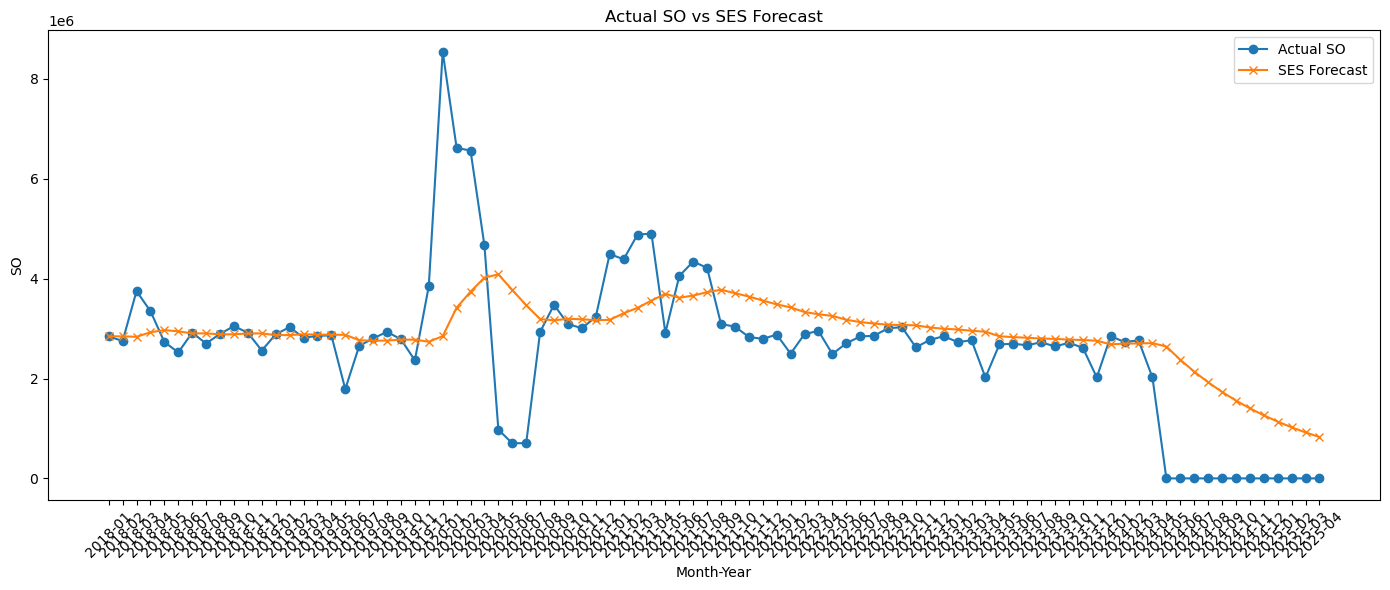

In [44]:
# Optional: Plot the actual vs forecasted values
plt.figure(figsize=(14, 6))
plt.plot(extended_data['bulan_tahun'].astype(str), extended_data['SO'], label='Actual SO', marker='o')
plt.plot(extended_data['bulan_tahun'].astype(str), extended_data['SES Forecast'], label='SES Forecast', marker='x')
plt.xlabel('Month-Year')
plt.ylabel('SO')
plt.xticks(rotation=45)
plt.title('Actual SO vs SES Forecast')
plt.legend()
plt.tight_layout()
plt.show()